In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')

In [165]:
train_df = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/train.csv")
test_df = pd.read_csv("/kaggle/input/rohlik-orders-forecasting-challenge/test.csv")

In [166]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [167]:
# Convert the date column to a processable format 
train_df["year"] = train_df['date'].dt.year
train_df["month_of_year"] = train_df['date'].dt.month
train_df["day"] = train_df['date'].dt.day
train_df["day_of_week"] = train_df['date'].dt.dayofweek
train_df["week_of_year"] = train_df['date'].dt.isocalendar().week.astype(int)

train_df["day_of_year"] = train_df['date'].dt.dayofyear
# Adjustment for leap years
train_df["day_of_year"] = np.where((train_df["year"] % 4 == 0) & (train_df["month_of_year"] > 2), 
                                   train_df["day_of_year"] - 1, 
                                   train_df["day_of_year"])

train_df["quarter"] = train_df['date'].dt.quarter
train_df["month_start"] = train_df['date'].dt.is_month_start.astype(int)
train_df["month_end"] = train_df['date'].dt.is_month_end.astype(int)
train_df["quarter_start"] = train_df['date'].dt.is_quarter_start.astype(int)
train_df["quarter_end"] = train_df['date'].dt.is_quarter_end.astype(int)

In [168]:
print('Train: ',min(train_df.date),max(train_df.date))
print('Test: ',min(test_df.date),max(test_df.date))

Train:  2020-12-05 00:00:00 2024-03-15 00:00:00
Test:  2024-03-16 00:00:00 2024-05-15 00:00:00


In [169]:
unique_warehouse = train_df['warehouse'].unique()
print(unique_warehouse)

['Prague_1' 'Brno_1' 'Prague_2' 'Prague_3' 'Munich_1' 'Frankfurt_1'
 'Budapest_1']


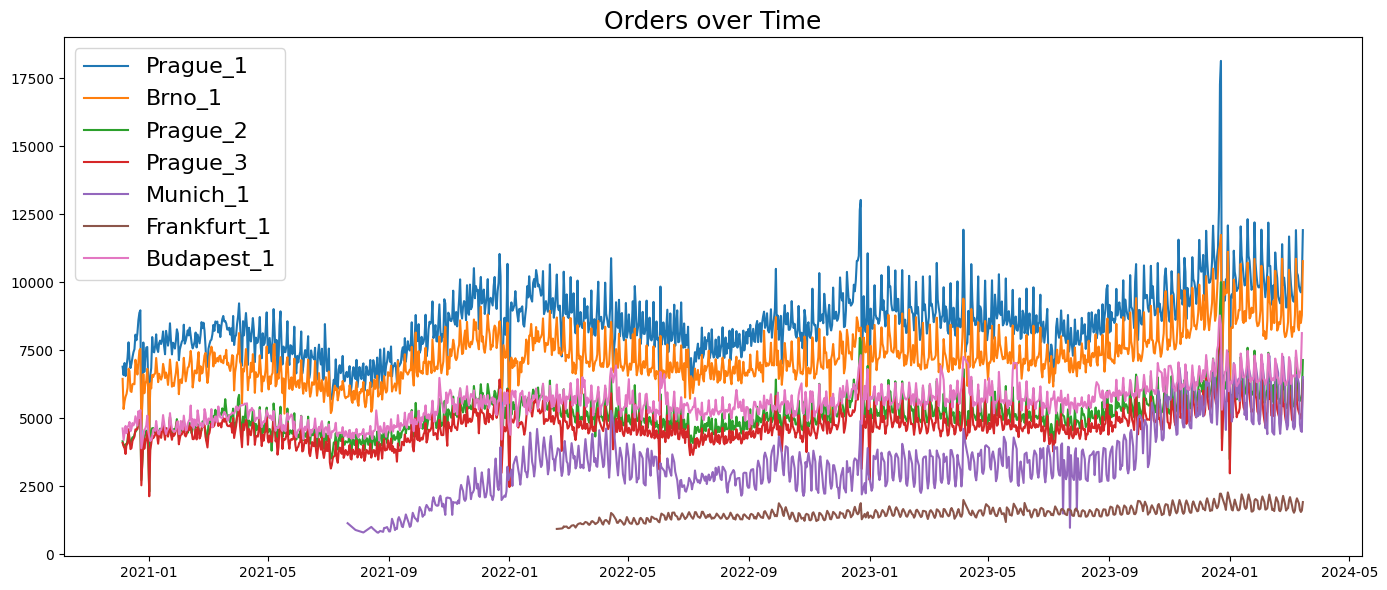

In [170]:
plt.figure(figsize=(14, 6))
for i, warehouse in enumerate(unique_warehouse):
    df_warehouse = train_df[train_df['warehouse'] == warehouse]
    sns.lineplot(x='date', y='orders', data=df_warehouse, label=warehouse)


plt.title('Orders over Time', fontsize=18)
plt.xlabel('')
plt.ylabel('')
plt.legend(fontsize=16) 
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [171]:
from scipy.optimize import curve_fit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import differential_evolution

In [172]:
def optimize_sinusoidal(data, period):
    def sin_func(x, A, B, C, D):
        return A * np.sin(B * x + C) + D

    def error_func(params):
        A, B, C, D = params
        y_pred = sin_func(np.arange(len(data)), A, B, C, D)
        return np.sum((data - y_pred) ** 2)

    bounds = [(0, np.std(data)), (2 * np.pi / period, 2 * np.pi / period), (0, 2 * np.pi), (np.mean(data) - np.std(data), np.mean(data) + np.std(data))]
    result = differential_evolution(error_func, bounds)
    return result.x

In [173]:
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

In [174]:
def visualize_sinusoidal_approximation(seasonal, amp_factor, freq_factor, phase_shift, mean_shift, label=''):
    x = np.arange(len(seasonal))
    sin_approx = amp_factor * np.sin(freq_factor * x + phase_shift) + mean_shift

    plt.figure(figsize=(12, 6))
    plt.plot(seasonal.index, seasonal, label=f'Seasonal Component {label}')
    plt.plot(seasonal.index, sin_approx, label=f'Sinusoidal Approximation {label}', color='red')
    plt.title(f'Sinusoidal Approximation of Seasonal Component {label}')
    plt.xlabel('Time')
    plt.ylabel('Seasonal Value')
    plt.legend()
    plt.show()

In [175]:
def find_best_alpha(data, regressors, alpha_range, model_type='ridge', window_size=62):
    tscv = TimeSeriesSplit(n_splits=5)
    best_alpha = None
    best_score = float('inf')

    for alpha in alpha_range:
        if model_type == 'ridge':
            model = Ridge(alpha=alpha)
        elif model_type == 'lasso':
            model = Lasso(alpha=alpha)
        elif model_type == 'elasticnet':
            model = ElasticNet(alpha=alpha)

        scores = []
        for train_index, val_index in tscv.split(regressors):
            X_train, X_val = regressors.iloc[train_index], regressors.iloc[val_index]
            y_train, y_val = data.iloc[train_index].values, data.iloc[val_index].values
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            score = np.mean((y_val - y_pred) ** 2)
            scores.append(score)

        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_alpha = alpha

    return best_alpha

In [177]:
def decompose_and_forecast(data, yearly_amp_factor, weekly_amp_factor, regressors, steps=62, period=365, model='additive', window_size=62, alpha=1.0):
    decomposed = seasonal_decompose(data, period=period, model=model, extrapolate_trend='freq')
    trend = moving_average(data, window_size=window_size)
    seasonal = decomposed.seasonal
    resid = decomposed.resid

    model = Ridge(alpha=alpha)
    X = regressors.iloc[-window_size:]
    y = data.iloc[-window_size:].values
    model.fit(X, y)

    trend_forecast = model.predict(regressors.iloc[-window_size:])
    trend_forecast = np.append(trend_forecast, [model.predict(regressors.iloc[-1:])] * (steps - window_size))

    yearly_params = optimize_sinusoidal(seasonal[-period:], period)
    weekly_params = optimize_sinusoidal(seasonal[-7:], 7)
    
    def sin_func(x, A, B, C, D):
        return A * np.sin(B * x + C) + D

    x_future = np.arange(len(seasonal), len(seasonal) + steps)
    seasonal_forecast_yearly = yearly_amp_factor * sin_func(x_future, *yearly_params)
    seasonal_forecast_weekly = weekly_amp_factor * sin_func(x_future, *weekly_params)

    forecast_values = trend_forecast + seasonal_forecast_yearly + seasonal_forecast_weekly
    forecast_index = pd.date_range(start=data.index[-1], periods=steps+1, freq='D')[1:]

    return pd.DataFrame({'forecast': forecast_values}, index=forecast_index)

In [202]:
def plot_forecast(data, forecast, regressors):
    plt.figure(figsize=(12, 8))
    plt.plot(data.index, data.values, label='Historical Data', color='teal')
    plt.plot(forecast.index, forecast['forecast'], label='Forecast', color='lightcoral')

    # We use a palette with the number of colors equal to the number of regressors
    cmap = plt.get_cmap('viridis')  # 'viridis', 'plasma', 'tab20'
    colors = [cmap(i) for i in np.linspace(0, 1, len(regressors.columns))]

    for i, regressor in enumerate(regressors.columns):
        plt.fill_between(regressors.index, 0, regressors[regressor] * data.max(), 
                         label=f'{regressor}', color=colors[i], alpha=0.15)

    plt.title('Forecast based on Trend and Seasonal Decomposition with Regressors')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [178]:
from sklearn.preprocessing import MinMaxScaler

def prepare_warehouse_data(train_df, warehouse_name, exclude_years=[]):
    warehouse_data = train_df[train_df['warehouse'] == warehouse_name]
    
    # We exclude data for certain years
    for year in exclude_years:
        warehouse_data = warehouse_data[warehouse_data['date'].dt.year != year]

    # Reset the index and set the date as the index
    warehouse_data.reset_index(drop=True, inplace=True)
    warehouse_data.set_index('date', inplace=True)

    # We restore the missing dates and fill in the gaps
    full_date_range = pd.date_range(start=warehouse_data.index.min(), end=warehouse_data.index.max(), freq='D')
    warehouse_data = warehouse_data.reindex(full_date_range)

    warehouse_data['orders'].fillna(method='ffill', inplace=True)
    warehouse_data['holiday'].fillna(0, inplace=True)
    warehouse_data['winter_school_holidays'].fillna(0, inplace=True)
    warehouse_data['shops_closed'] = warehouse_data['shops_closed'].fillna(1)
    
    warehouse_data['month_of_year'].fillna(0, inplace=True)
    warehouse_data['day_of_week'].fillna(0, inplace=True)
    warehouse_data['day_of_year'].fillna(0, inplace=True)
    warehouse_data['week_of_year'].fillna(0, inplace=True)
    warehouse_data['quarter'].fillna(0, inplace=True)
    warehouse_data['month_start'].fillna(0, inplace=True)
    warehouse_data['month_end'].fillna(0, inplace=True)
    warehouse_data['quarter_start'].fillna(0, inplace=True)
    warehouse_data['quarter_end'].fillna(0, inplace=True)
    
    # Scaling the regressors
    scaler = MinMaxScaler()
    columns_to_scale = ['holiday', 'winter_school_holidays', 'shops_closed', 
                        'month_of_year', 'day_of_week', 'day_of_year',
                        'week_of_year', 'quarter', 'month_start',
                        'month_end', 'quarter_start', 'quarter_end']
    
    warehouse_data[columns_to_scale] = scaler.fit_transform(warehouse_data[columns_to_scale])
    
    return warehouse_data

In [179]:
def set_weights(warehouse_data, warehouse_name):
    weights = np.ones(len(warehouse_data))

    weights[warehouse_data['holiday'] == 1] = 2
    weights[warehouse_data['winter_school_holidays'] == 1] = 1.5

    weights[warehouse_data['day_of_week'] == 4] = 1.5  # Friday
    weights[warehouse_data['day_of_week'] == 0] = 1.1  # Monday
    weights[warehouse_data['day_of_week'] == 5] = 1.3  # Saturday
    weights[warehouse_data['day_of_week'] == 6] = 1.2  # Sunday
    
    # Emissions-based weights
    lower_threshold = warehouse_data['orders'].quantile(0.03)  # 3rd percentile
    upper_threshold = warehouse_data['orders'].quantile(0.98)  # 98th percentile
    
    # We assign negative weights for values below the lower threshold
    weights[warehouse_data['orders'] < lower_threshold] = -0.5
    
    # We assign positive weights for values above the upper threshold
    weights[warehouse_data['orders'] > upper_threshold] = -0.5
    
    return weights

Best alpha for Prague_1: 247.70763559917089


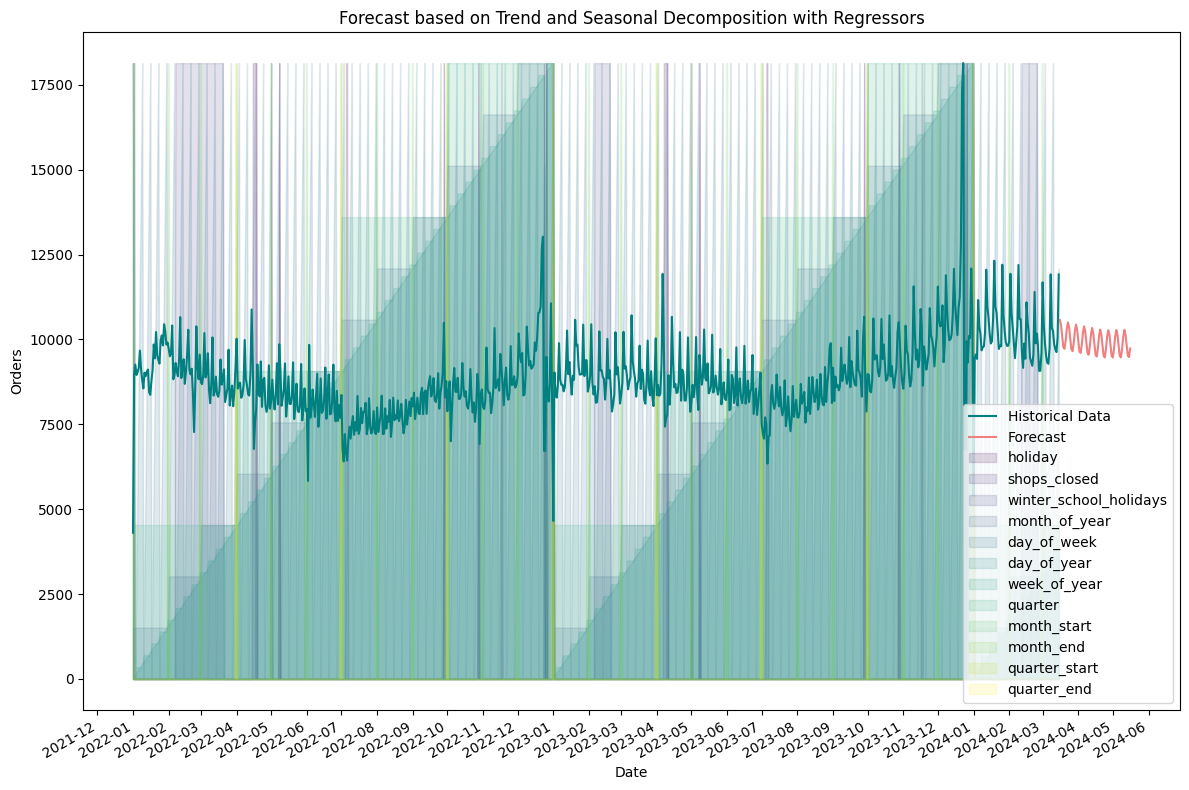

Best alpha for Brno_1: 138.48863713938718


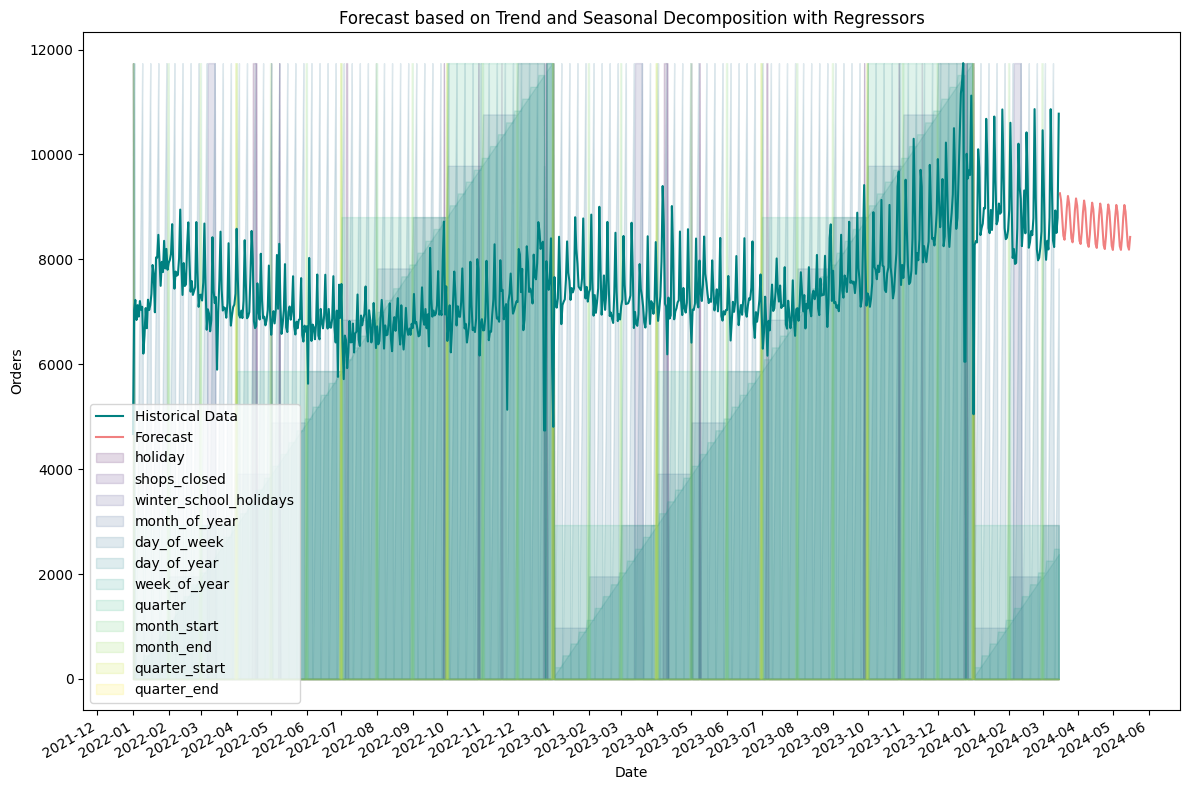

Best alpha for Prague_2: 123.28467394420659


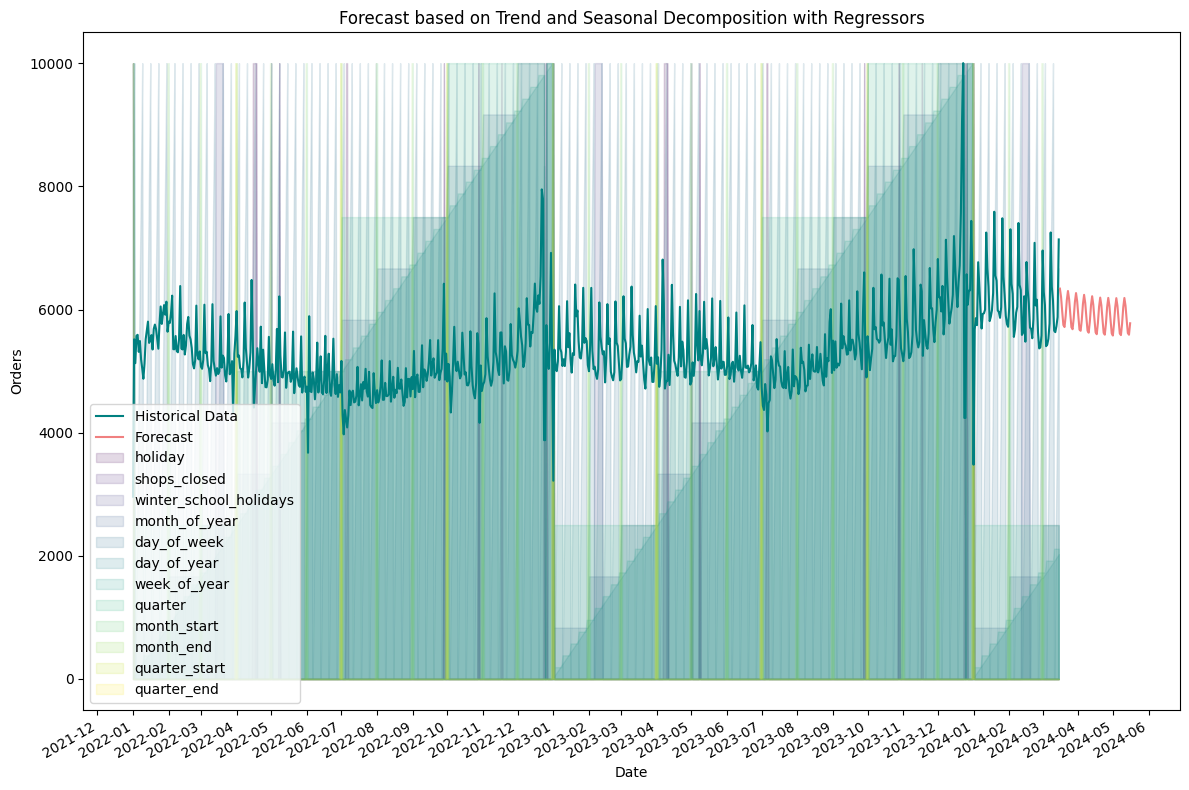

Best alpha for Prague_3: 123.28467394420659


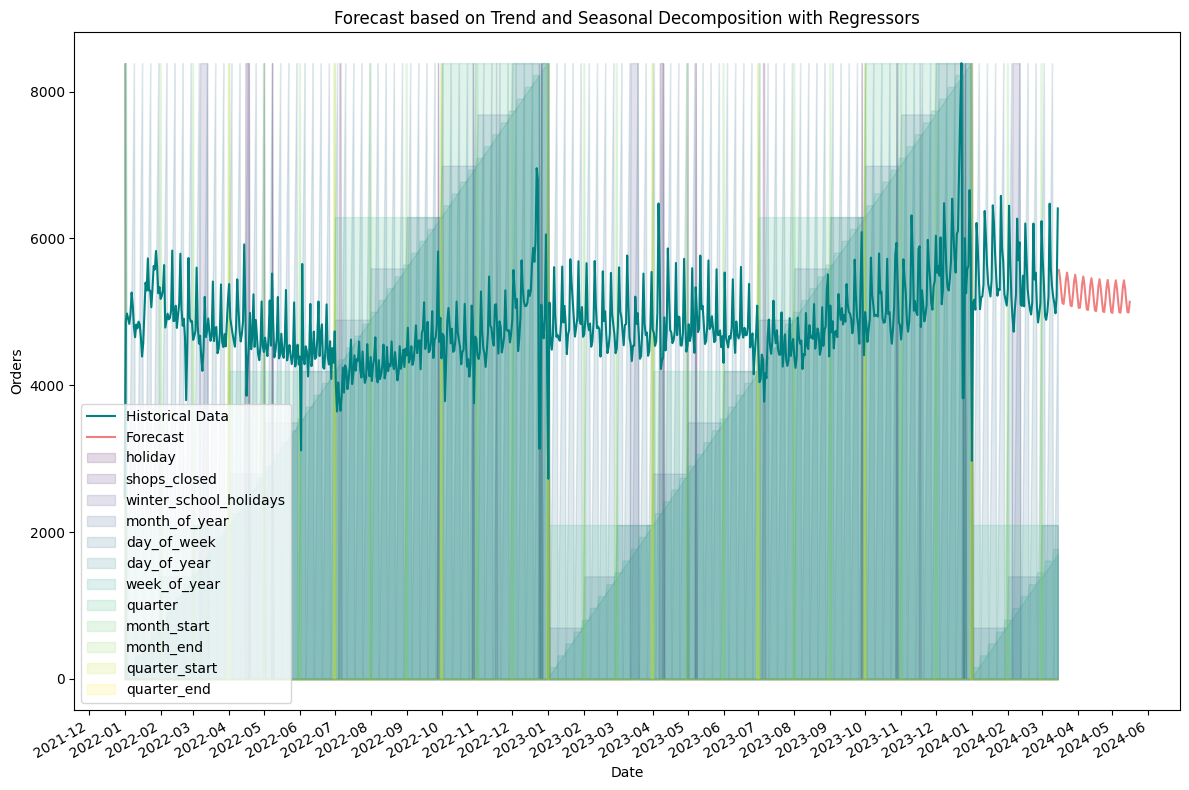

Best alpha for Munich_1: 0.18307382802953678


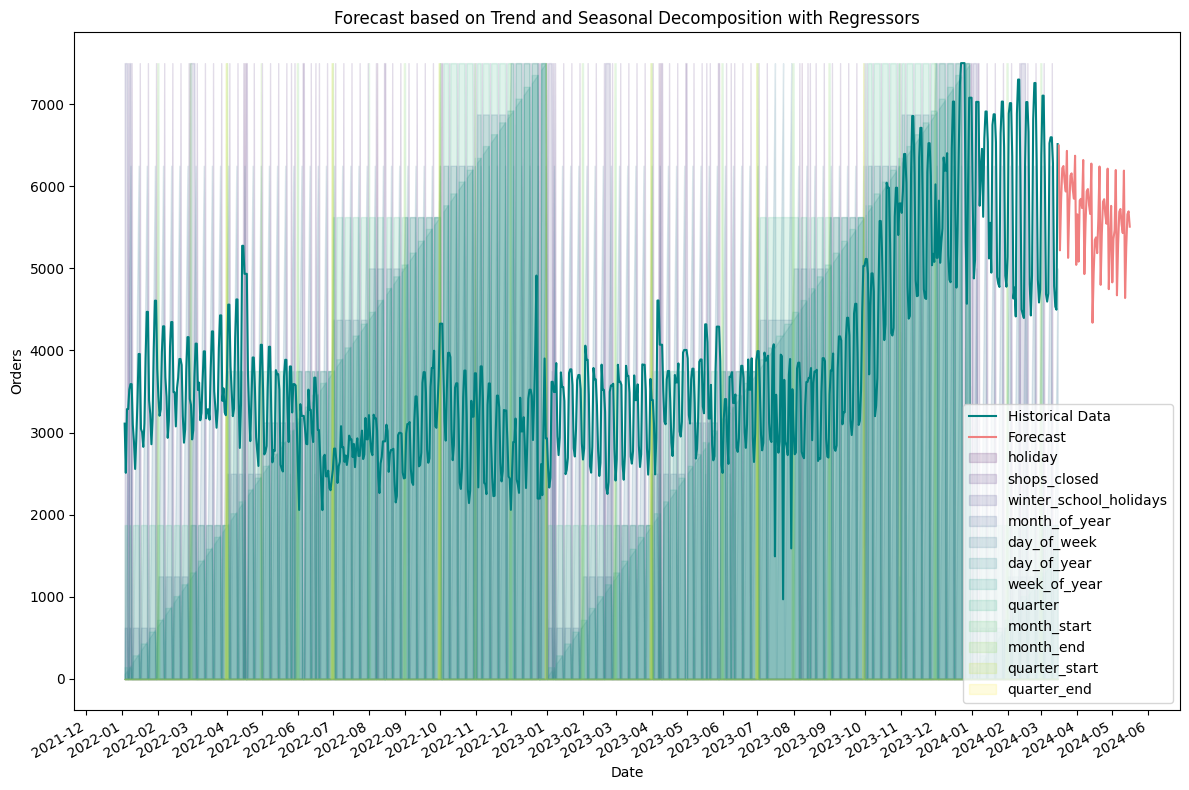

Best alpha for Frankfurt_1: 0.07220809018385464


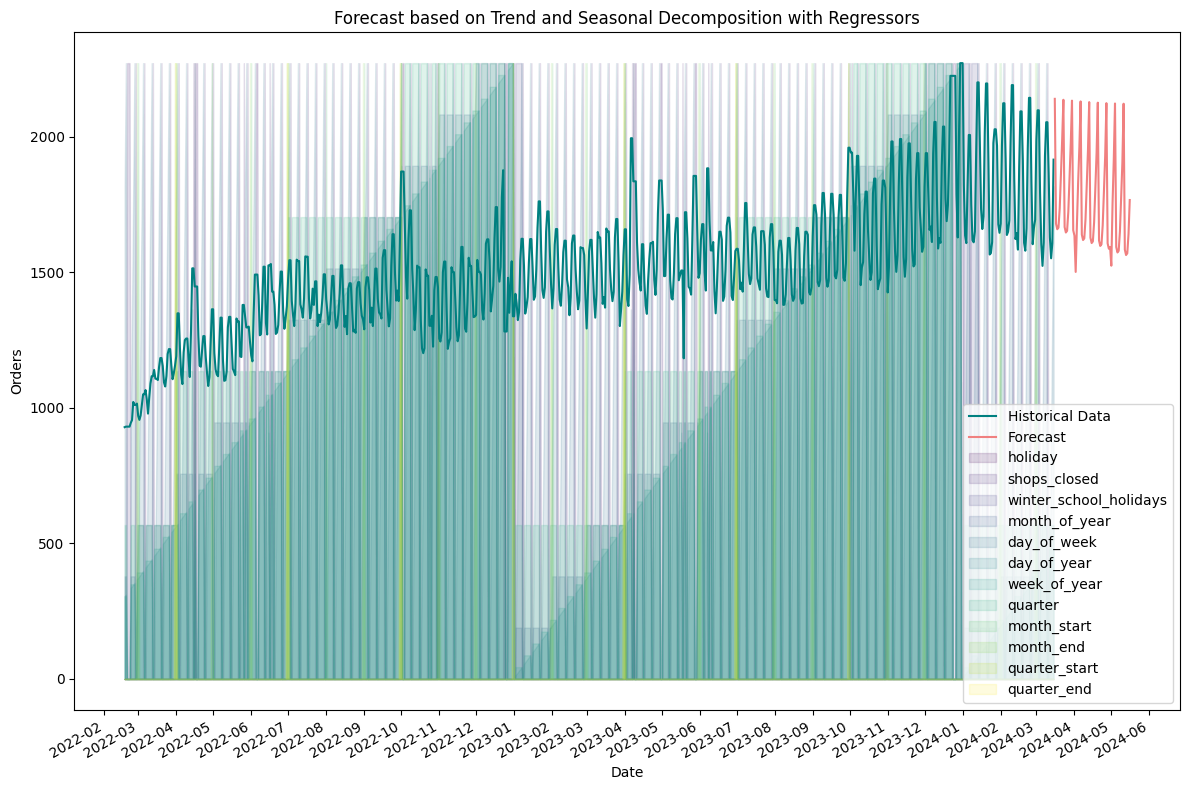

Best alpha for Budapest_1: 86.97490026177834


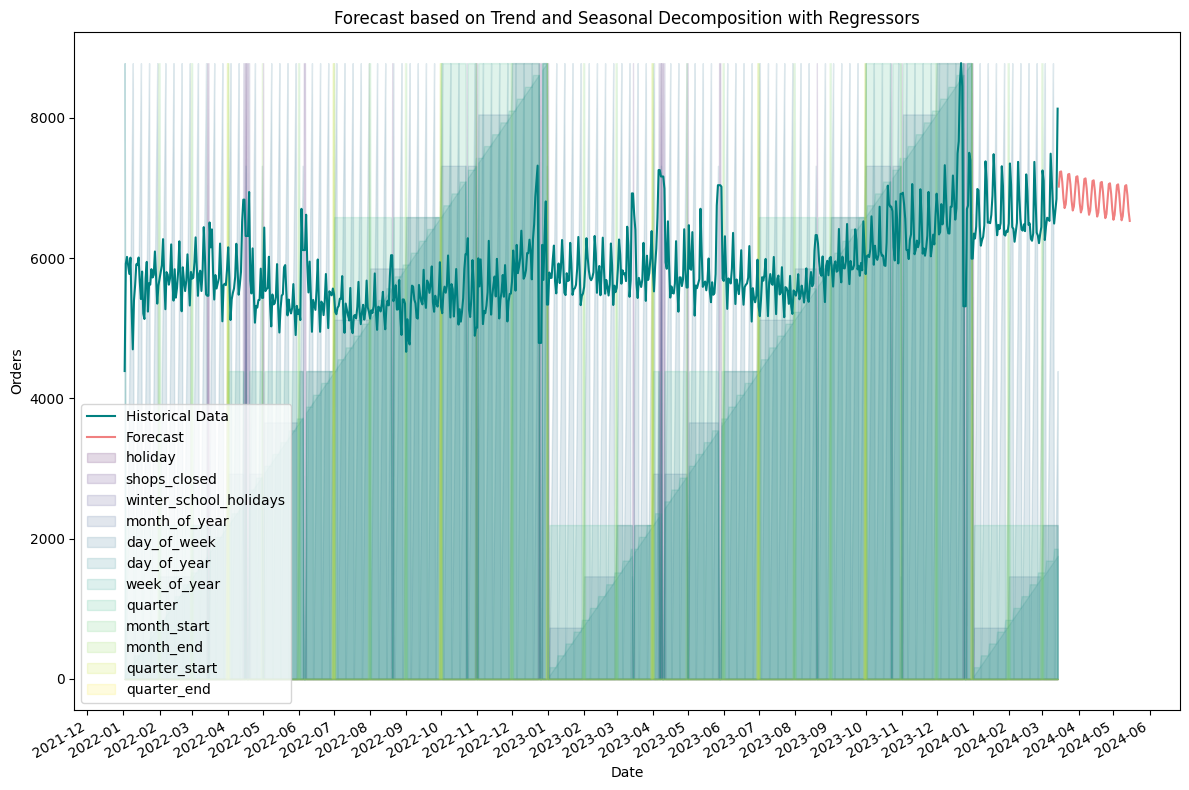

In [203]:
warehouse_data = {}
warehouses = ['Prague_1', 'Brno_1', 'Prague_2', 'Prague_3', 'Munich_1', 'Frankfurt_1', 'Budapest_1']
alpha_range = np.logspace(-2, 3, 100)

exclude_years = {
    'Prague_1': [2020, 2021],
    'Brno_1': [2020, 2021],
    'Prague_2': [2020, 2021],
    'Prague_3': [2020, 2021],
    'Munich_1': [2021, 2021],
    'Frankfurt_1': [2021],
    'Budapest_1': [2020, 2021]
}

combined_forecasts = pd.DataFrame()

for warehouse_name in warehouses:
    warehouse_data[warehouse_name] = prepare_warehouse_data(train_df, warehouse_name, exclude_years.get(warehouse_name, []))
      
    regressors = warehouse_data[warehouse_name][['holiday', 
                                                 'shops_closed', 
                                                 'winter_school_holidays', 
                                                 'month_of_year', 
                                                 'day_of_week', 
                                                 'day_of_year', 
                                                 'week_of_year',
                                                 'quarter',
                                                 'month_start',
                                                 'month_end',
                                                 'quarter_start',
                                                 'quarter_end'
                                                ]]

    # Weights
    weights = set_weights(warehouse_data[warehouse_name], warehouse_name)
    
    best_alpha = find_best_alpha(warehouse_data[warehouse_name]['orders'], regressors, alpha_range, model_type='elasticnet')
    print(f'Best alpha for {warehouse_name}: {best_alpha}')

    forecast_results = decompose_and_forecast(warehouse_data[warehouse_name]['orders'],
                                                              yearly_amp_factor=1.0,
                                                              weekly_amp_factor=1.0,
                                                              regressors=regressors,
                                                              alpha=best_alpha)

    combined_forecasts = pd.concat([combined_forecasts, forecast_results.rename(columns={'forecast': warehouse_name})], axis=1)
    plot_forecast(warehouse_data[warehouse_name]['orders'], forecast_results, regressors)

    yearly_params = optimize_sinusoidal(warehouse_data[warehouse_name]['orders'].dropna(), 365)
    #visualize_sinusoidal_approximation(warehouse_data[warehouse_name]['orders'].dropna(), *yearly_params, label='Yearly')

    weekly_params = optimize_sinusoidal(warehouse_data[warehouse_name]['orders'].dropna(), 7)
    #visualize_sinusoidal_approximation(warehouse_data[warehouse_name]['orders'].dropna(), *weekly_params, label='Weekly')

In [181]:
submission = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv')

submission[['warehouse', 'date']] = submission['id'].str.rsplit('_', n=1, expand=True)
submission['date'] = pd.to_datetime(submission['date'])

def get_forecast_value(row):
    warehouse = row['warehouse']
    date = row['date']
    return combined_forecasts.loc[date, warehouse]

submission['orders'] = submission.apply(get_forecast_value, axis=1)
submission = submission.drop(columns=['warehouse', 'date'])

In [182]:
submission.head()

,id,orders
0,Prague_1_2024-03-16,10574.565679
1,Prague_1_2024-03-17,10419.974961
2,Prague_1_2024-03-18,10083.967160
3,Prague_1_2024-03-19,9776.070518
4,Prague_1_2024-03-20,9724.567079


In [183]:
submission.tail(5)

,id,orders
392,Budapest_1_2024-05-11,7026.967786
393,Budapest_1_2024-05-12,7038.686122
394,Budapest_1_2024-05-13,6894.164362
395,Budapest_1_2024-05-14,6665.294714
396,Budapest_1_2024-05-15,6527.973079


In [184]:
submission.to_csv('submission.csv', index=False)